In [1]:
import numpy as np 
import pandas as pd 
import pickle

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
from utils.stats import *
from utils.tools import *
viz.get_style()

In [2]:
def test_perform_target(ax, pred_data, tar_data_set, block_type='block', color=viz.Blue):
    # preprocess the model prediction
    pred_data['r'] = pred_data['acc']
    pred_data = pred_data.query(f'stage=="test"&block_type=="{block_type}"').groupby(
        by=['sub_id', 'group'])['r'].mean().reset_index()
    pred_data['agent'] = 'model'
    # preprocess the target data
    tar_data  = get_sim_data(tar_data_set, 'human')
    tar_data['group'] = tar_data['group'].map(
        {'control': 'trained', 'trained': 'trained', 
         'untrained': 'untrained', 'probe': 'probe'}
    )
    tar_data = tar_data.query(f'stage=="test"&block_type=="{block_type}"').groupby(
        by=['sub_id', 'group'])['r'].mean().reset_index()
    tar_data['agent'] = 'human'
    # combine data
    comb_data = pd.concat([pred_data, tar_data], axis=0, ignore_index=True)    
    # visualize
    viz.violin_with_tar(ax=ax, 
            data=comb_data, y='r', 
            x='group', order=['trained', 'untrained'], 
            color=color, errorbar='sd',
            errorcolor=[.38]*3, err_capsize=.15,
            errorlw=3.2, scatter_size=2,
            hue='agent', hue_order=['human', 'model'])
    ax.axhline(y=.5, xmin=0, xmax=1, lw=1.2, 
            color=[.2, .2, .2], ls='--')
    ax.set_xticks([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticklabels(['Trained', 'Untrained'], fontsize=14)
    ax.spines['left'].set_position(('axes',-0.08))
    ax.set_xlabel('')
    ax.set_ylabel('Acc.')
    ax.set_ylim([-.05, 1.1])

In [3]:
def show_gen_supp(axs, data_set, model, method):
    pred_data = get_sim_data(data_set, model, method=method)
    pred_data['r'] = pred_data['acc']
    pred_data['group'] = pred_data['group'].map(
        {'control': 'trained', 'trained': 'trained', 
            'untrained': 'untrained', 'probe': 'probe'}
    )
    block_types = ['cons', 'cont', 'conf']
    block_titles = ['Consistent', 'Control', 'Conflict']
    for i, block_type in enumerate(block_types):
        ax = axs[i]
        test_perform_target(ax, pred_data, tar_data_set=data_set,
                            block_type=block_type, color=viz.Pal_type[i])
        for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.5)
        ax.set_title(block_titles[i])
        ax.set_box_aspect(1.1)

In [4]:
def learning_curve_exp2(ax, data, with_target_data_set=False):
    # show the curve
    data = data.query('group in ["control", "trained"]').copy()
    data['tps'] = data.apply(
        lambda x: x['tps']+(x['stage']=="test")*10
    , axis=1)
    sel_data = data.groupby(
        by=['sub_id', 'tps', 'block_type'])['r'].mean().reset_index()
    if with_target_data_set==False:
        # visualize
        sns.lineplot(x='tps', y='r', data=sel_data, 
                    hue='block_type', hue_order=['cons', 'cont', 'conf'],
                    err_style='bars', errorbar="se", 
                    palette=viz.Pal_type,
                    legend=False,
                    lw=2.5,
                    err_kws={'capsize': 3.5, 'elinewidth': 2.5, 'capthick': 2.5},
                    ax=ax)
    else:
        # get target
        target_data = get_sim_data(with_target_data_set, 'human').query('group in ["control", "trained"]')
        target_data['tps'] = target_data.apply(
            lambda x: x['tps']+(x['stage']=="test")*10
        , axis=1)
        target_data = target_data.groupby(
                by=['sub_id', 'tps', 'block_type'])['r'].mean().reset_index()
        # visualize the model prediction 
        sns.lineplot(x='tps', y='r', data=sel_data, 
                    hue='block_type', hue_order=['cons', 'cont', 'conf'],
                    err_style='band', errorbar="se", 
                    palette=viz.Pal_type,
                    err_kws={'alpha':.55}, 
                    legend=False,
                    lw=0,
                    ax=ax)
        # show the target data 
        sns.lineplot(x='tps', y='r', data=target_data, 
                    lw=0,
                    ax=ax, 
                    legend=False,
                    hue='block_type', hue_order=['cons', 'cont', 'conf'],
                    err_style='bars', errorbar="se", 
                    palette=viz.Pal_type,
                    err_kws={'capsize': 4.5, 'elinewidth': 2.5, 'capthick': 2.5})
    ax.axvline(x=9.5, ymax=0, ymin=1, ls='--', color='k', lw=1)
    #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(3)
    ax.spines['left'].set_position(('axes',-0.05))
    ax.set_box_aspect(.6)
    ax.set_xticks([0, 5, 10, 15])
    ax.set_xticklabels([1, 6, 11, 16])
    ax.set_yticks([.5, .6, .7, .8, .9])
    ax.set_yticklabels([.5, '', .7, '', .9])
    ax.set_ylabel('Acc.')
    ax.set_xlabel('#Exposures per associations')
    ax.set_ylim([.45, .95])

In [5]:
def viz_probe(axs, data_set, models, method, goodPoor=None):
    n = len(models) 
    for i, m in enumerate(models):
        if m == 'human':
            fname = f'{pth}/../data/{data_set}-human.csv'
            s = 1
        else:
            fname = f'{pth}/../simulations/{data_set}/{m}/sim-{method}.csv'
            s = 10
        data = pd.read_csv(fname, index_col=0)
        sel_data = data.query('group=="probe"').reset_index()
        for j, cond in enumerate(['cons', 'cont', 'conf']):
            ax = axs[i, j] if n > 1 else axs[j]
            sdata = sel_data.query(f'block_type=="{cond}"')
            if goodPoor is not None: sdata = sdata.query(f'goodPoor=="good"') 
            gdata = sdata.groupby(by=['sub_id', 'a', 'block_type']).count()['r'].reset_index()
            ptable = gdata.pivot_table(values='r', index='sub_id', columns='a').fillna(0) / (6*s)
            ptable.columns = [0, 1, 2, 3]
            ptable = ptable.reset_index()
            ptable = ptable.melt(id_vars='sub_id', value_vars=[0, 1, 2, 3]
                        ).rename(columns={'variable': 'a', 'value':'prop'})
        
            sns.stripplot(x='a', y='prop', data=ptable, 
                        color=viz.Pal_type[j], #dodge=True, 
                        edgecolor='auto', size=1.8,
                        jitter=True, alpha=.7,
                        legend=False, zorder=2,
                        ax=ax)
            sns.violinplot(x='a', y='prop', data=ptable,
                        legend=False, alpha=.5, inner=None,
                        density_norm='width', edgecolor=[.8]*3,
                        color=viz.Pal_type[j],
                        ax=ax)
            sns.barplot(x='a', y='prop', data=ptable,
                        width=.75, errorbar=('ci', 95), lw=2.2,
                        edgecolor=viz.Pal_type[j], 
                        facecolor=viz.Pal_type[j].tolist()+[.2],
                        err_kws={'color': [.2, .2, .2], 'linewidth': 2.1},
                        capsize=.2,
                        color='w', ax=ax)
            #ax.set_box_aspect(.9)
            ax.set_xlabel('')
            
            ax.set_ylim([0, 1.1])
            if j==1: ax.set_title(eval(m).name, fontsize=12)
                
            for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(3)
            if j==0:
                ax.spines['left'].set_visible(True)
                ax.spines['left'].set_position(('axes',-0.05))
                # ax.set_yticks([0, 1])
                # ax.set_yticklabels([.5, 1])
                ax.set_yticks([])
                ax.set_ylabel('')
            else:
                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.set_ylabel('')
            if i==n-1:
                ax.set_xticks(range(4)) 
                #ax.set_xticks([]) 
                ax.set_xticklabels([r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$'], fontsize=12)
            else:
                ax.set_xticks([]) 


In [6]:
def get_phi(data_set, model, method):
    gridsize = (4, 6)
    fig = plt.figure(figsize=(9.3, 6.5))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 2), colspan=2, rowspan=2)
    ax3 = plt.subplot2grid(gridsize, (0, 4), colspan=2, rowspan=2)
    ax4 = plt.subplot2grid(gridsize, (2, 0), colspan=3, rowspan=2)
    axs_probe = np.array([[plt.subplot2grid(gridsize, (2+j, 3+i), colspan=1, rowspan=1) 
                        for i in range(3)] for j in range(2)])
    show_gen_supp([ax1, ax2, ax3], data_set, model, method)
    learning_curve_exp2(ax4, get_sim_data(data_set, model, method), with_target_data_set=data_set)
    show_probe_supp(axs_probe, 'exp2', ['human']+[model], method='map')
    for ax in [ax2, ax3]:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.32)

## ECPG

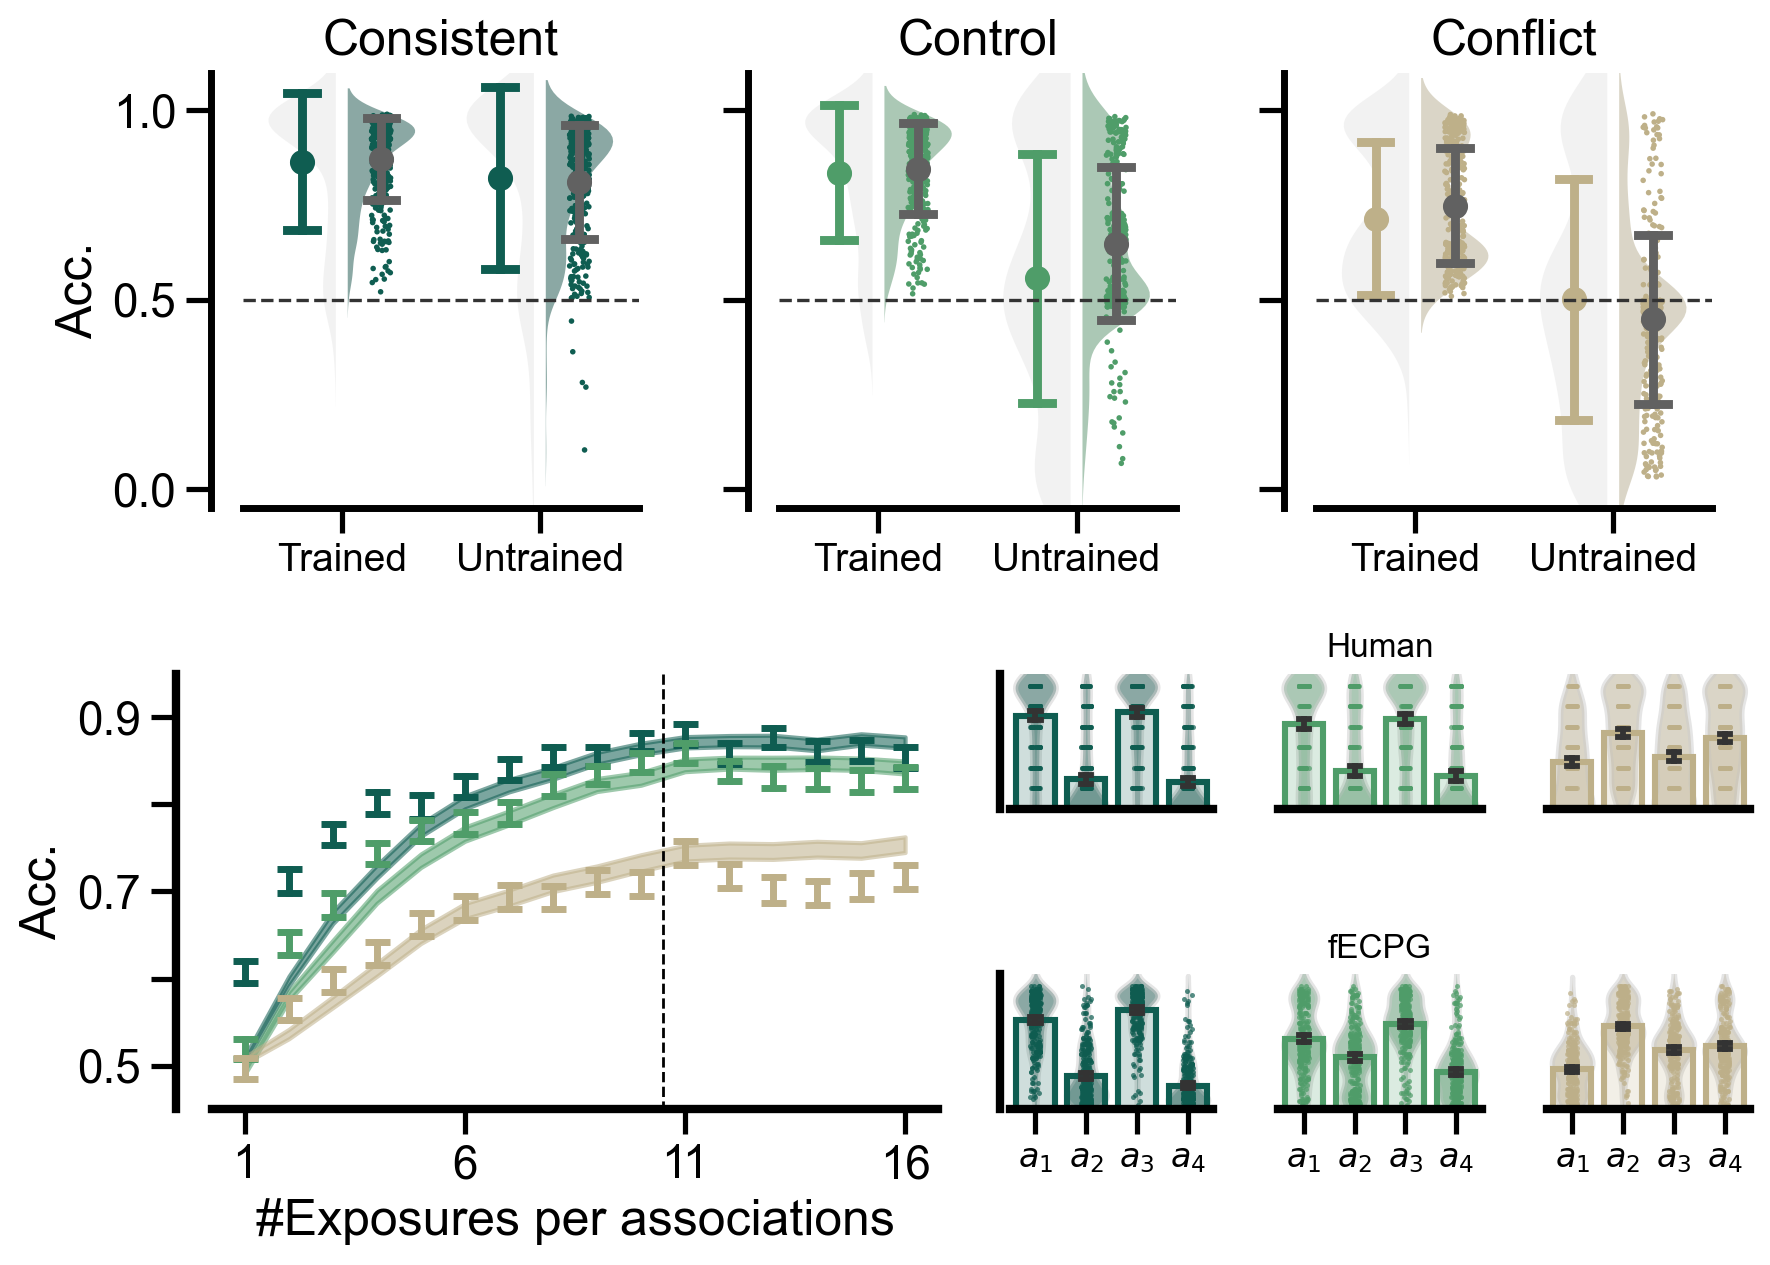

In [17]:
data_set = 'exp2'
model = 'ecPG_fea'
method = 'map'
get_phi(data_set, model, method)
plt.savefig('sample.pdf', dpi=300)

## LC

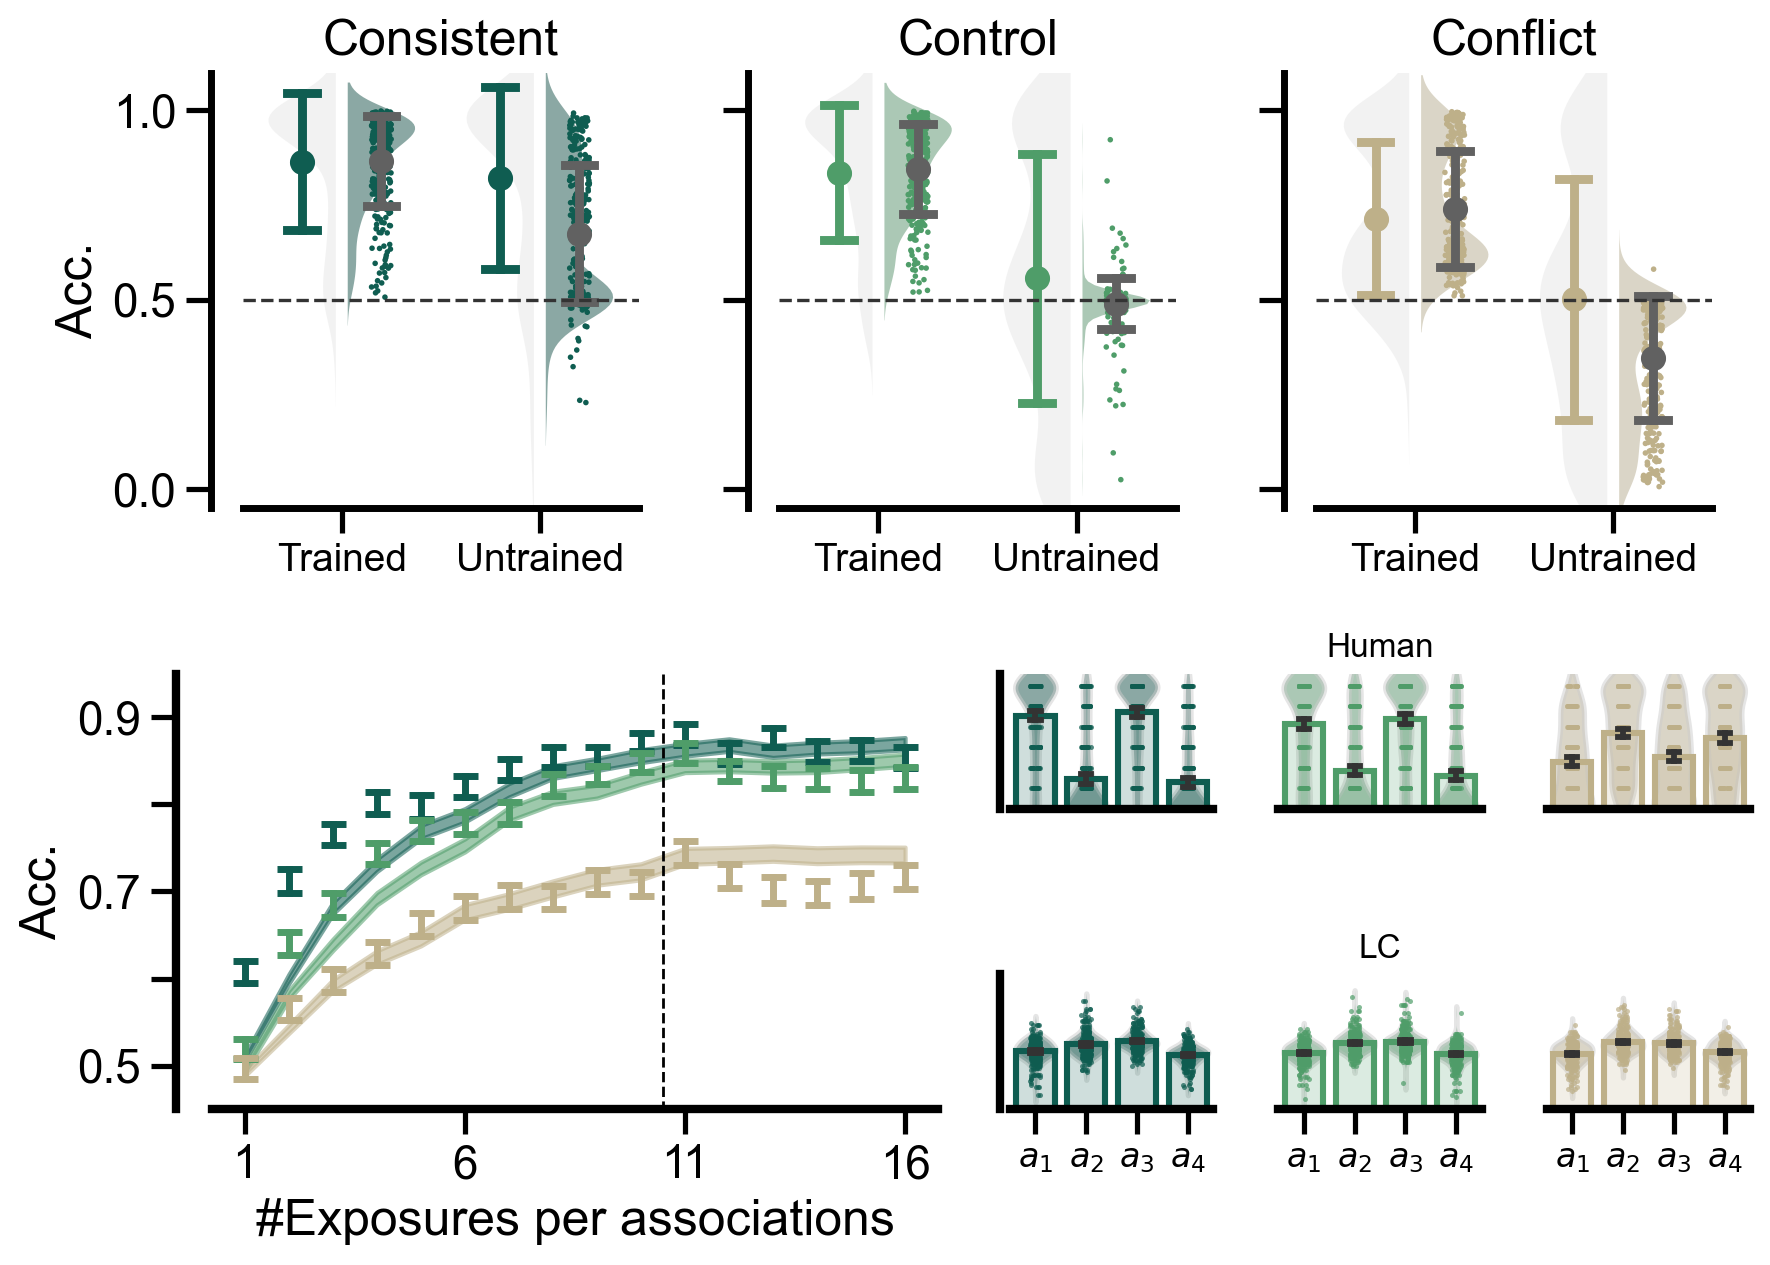

In [7]:
data_set = 'exp2'
model = 'LC'
method = 'map'
get_phi(data_set, model, method)

## MA

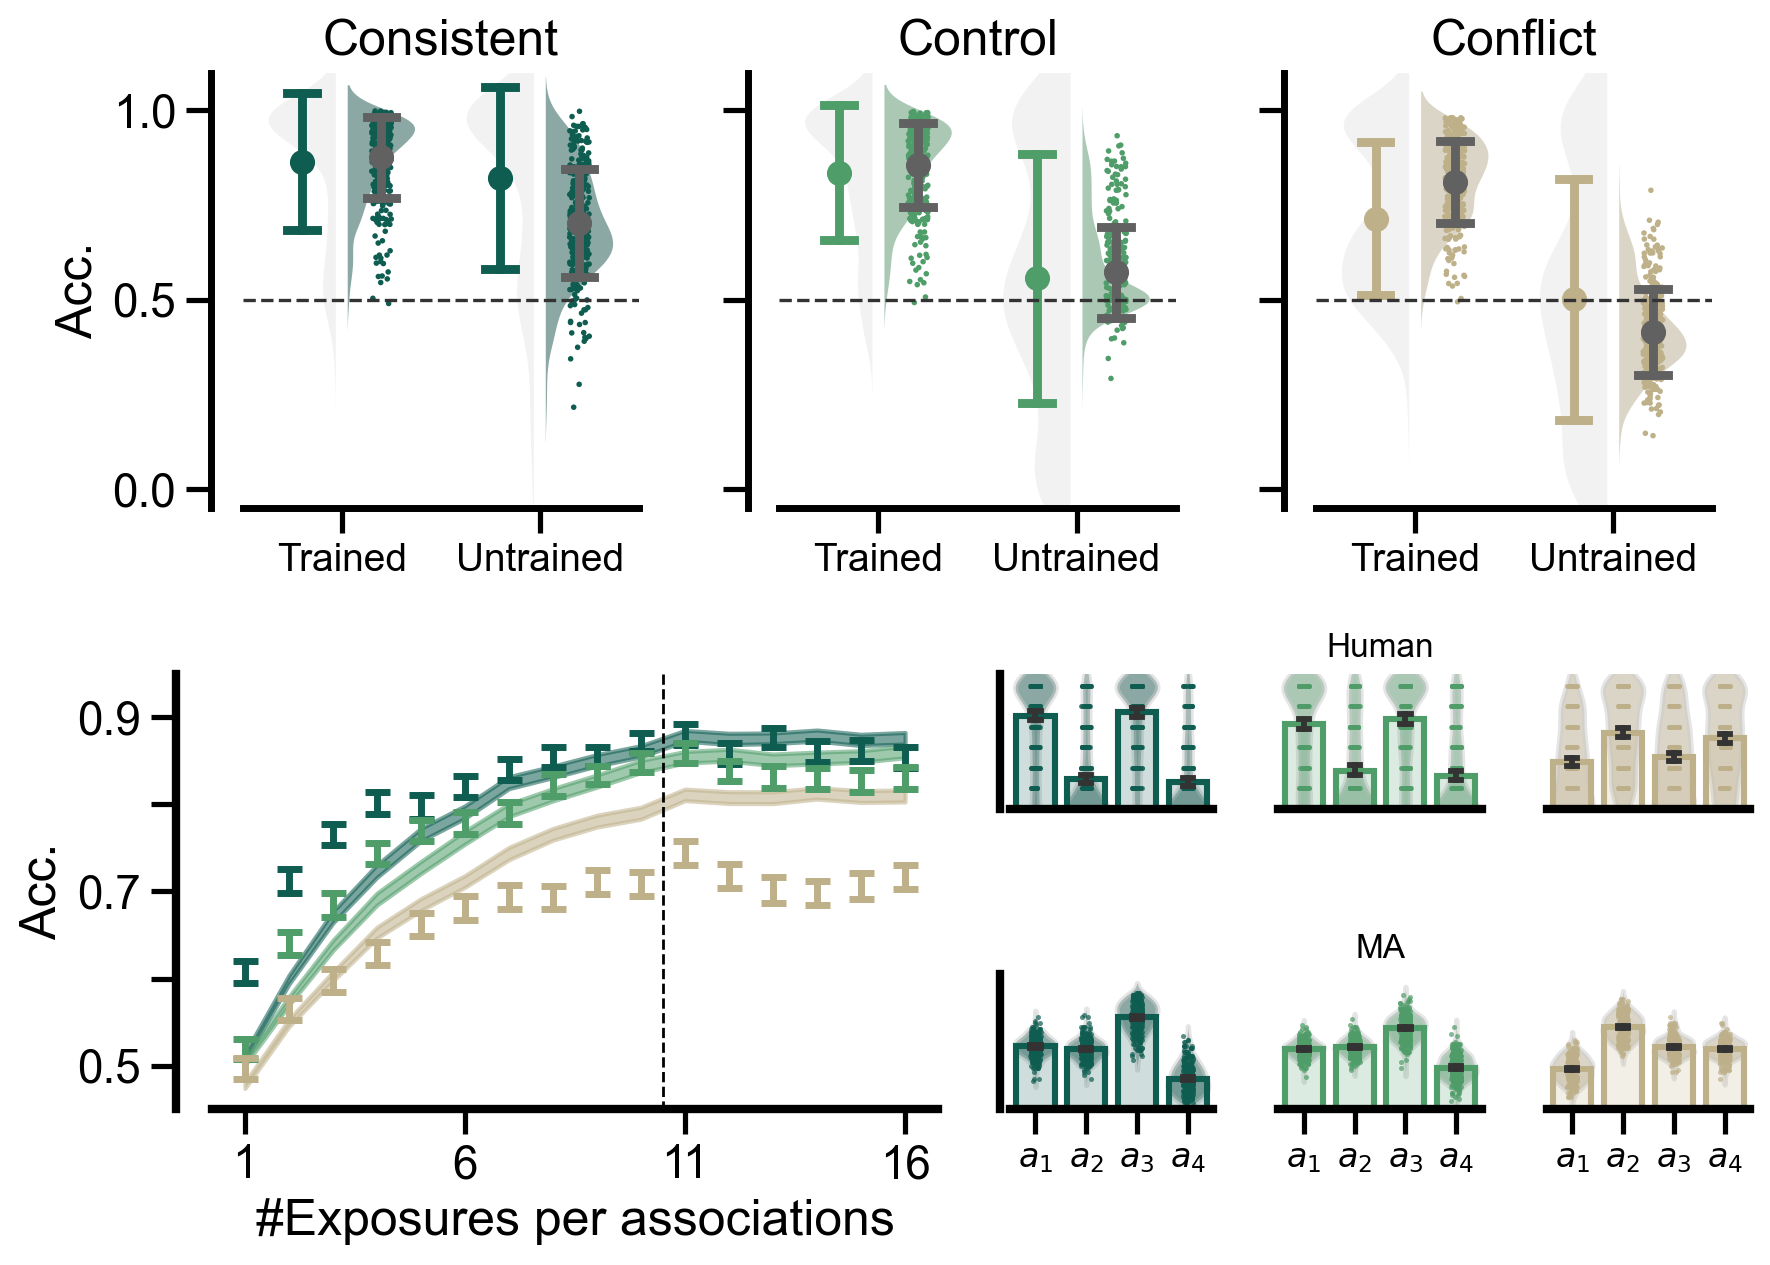

In [8]:
data_set = 'exp2'
model = 'MA'
method = 'map'
get_phi(data_set, model, method)

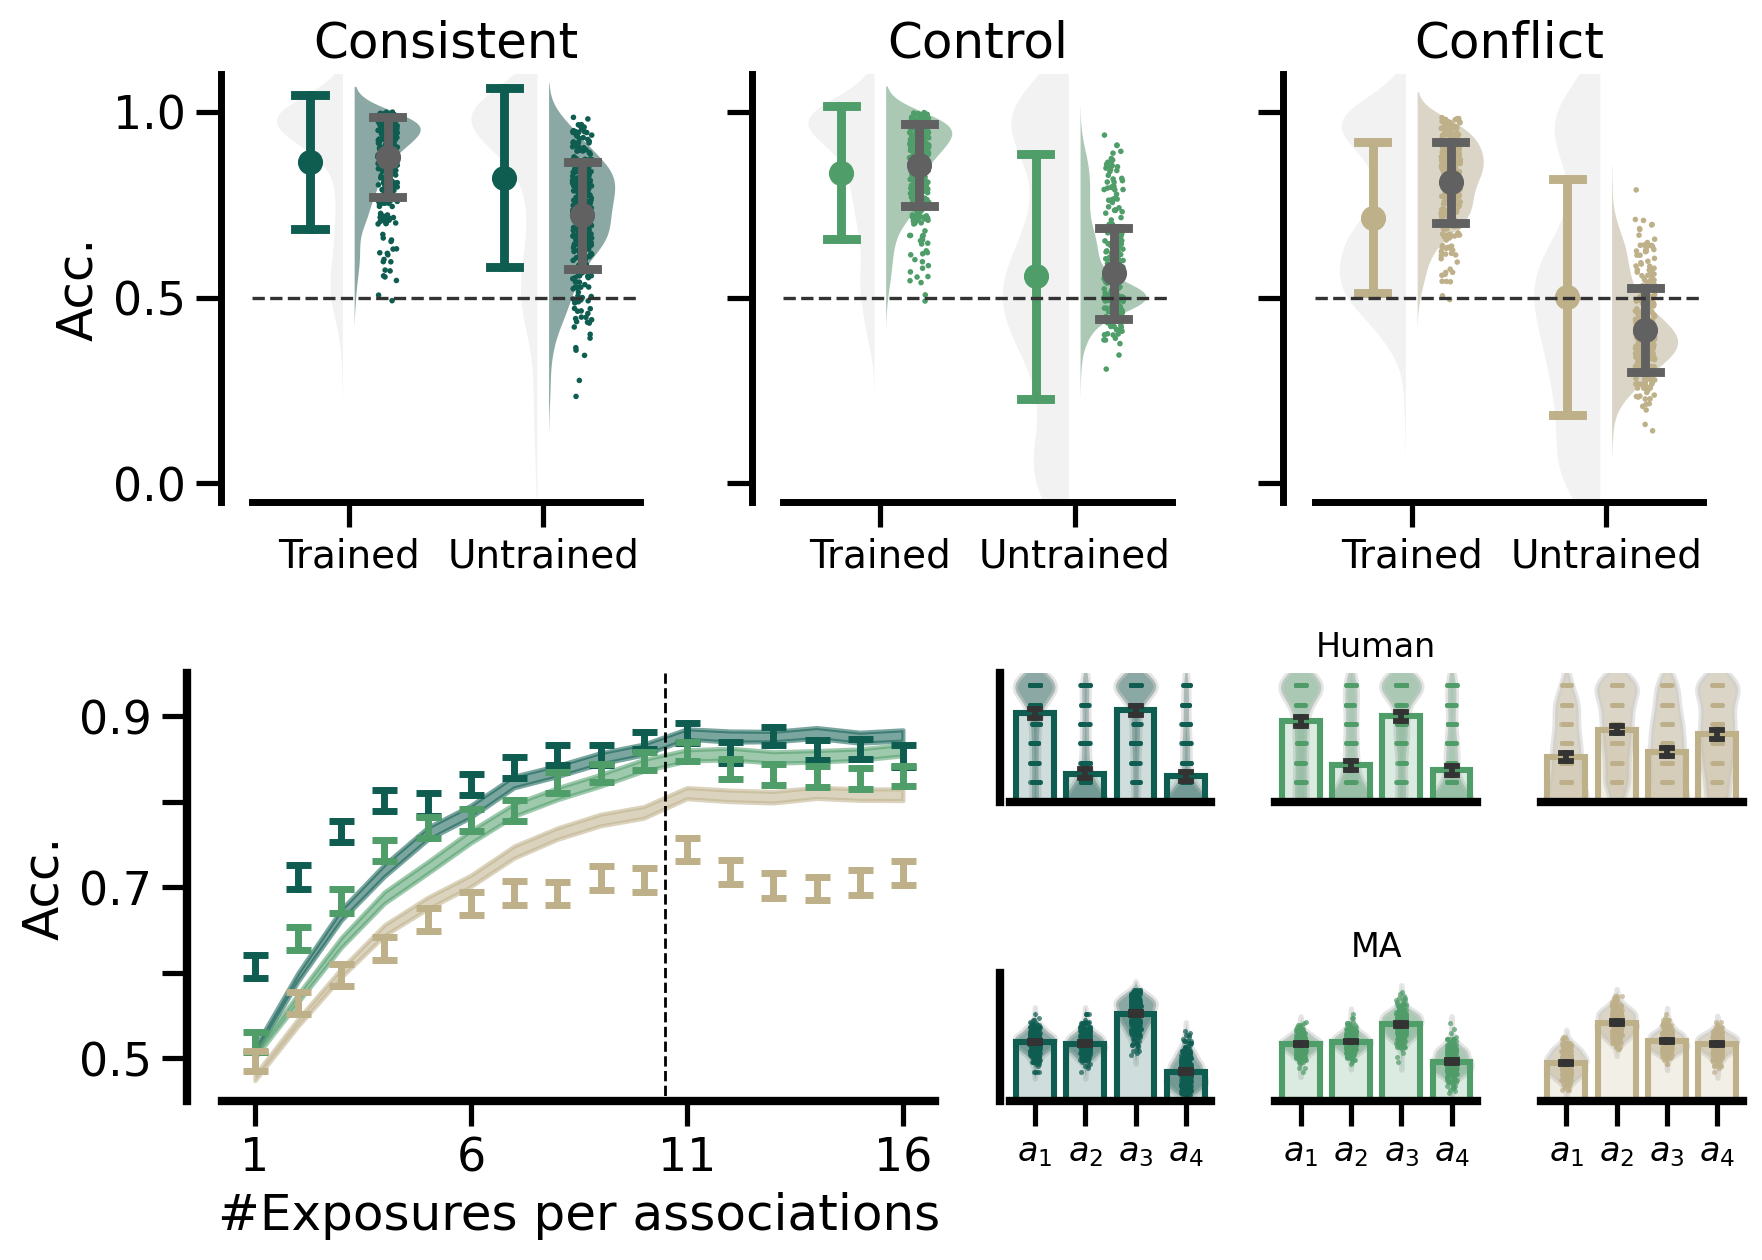

In [8]:
data_set = 'exp2'
model = 'MA2'
method = 'map'
get_phi(data_set, model, method)

## ACL

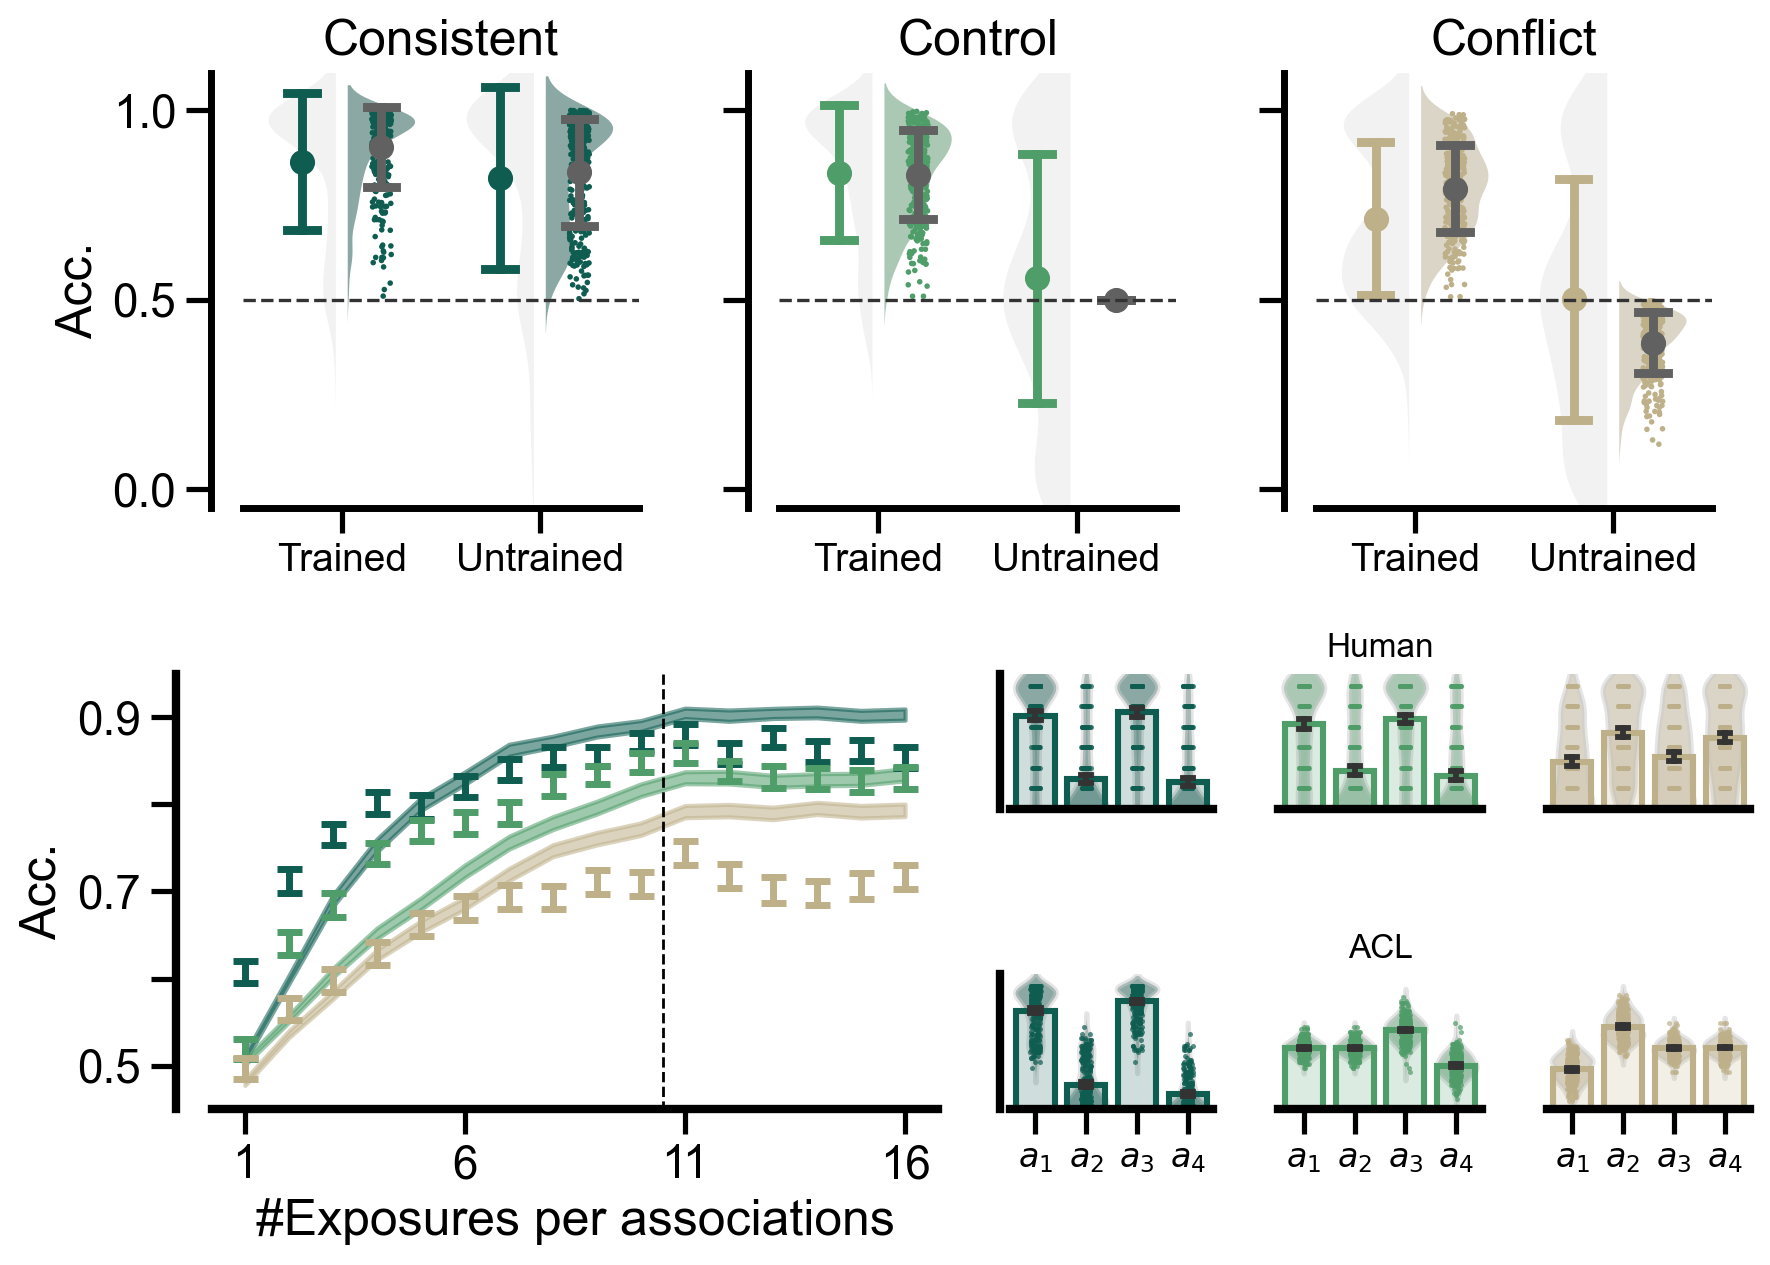

In [9]:
data_set = 'exp2'
model = 'ACL'
method = 'map'
get_phi(data_set, model, method)

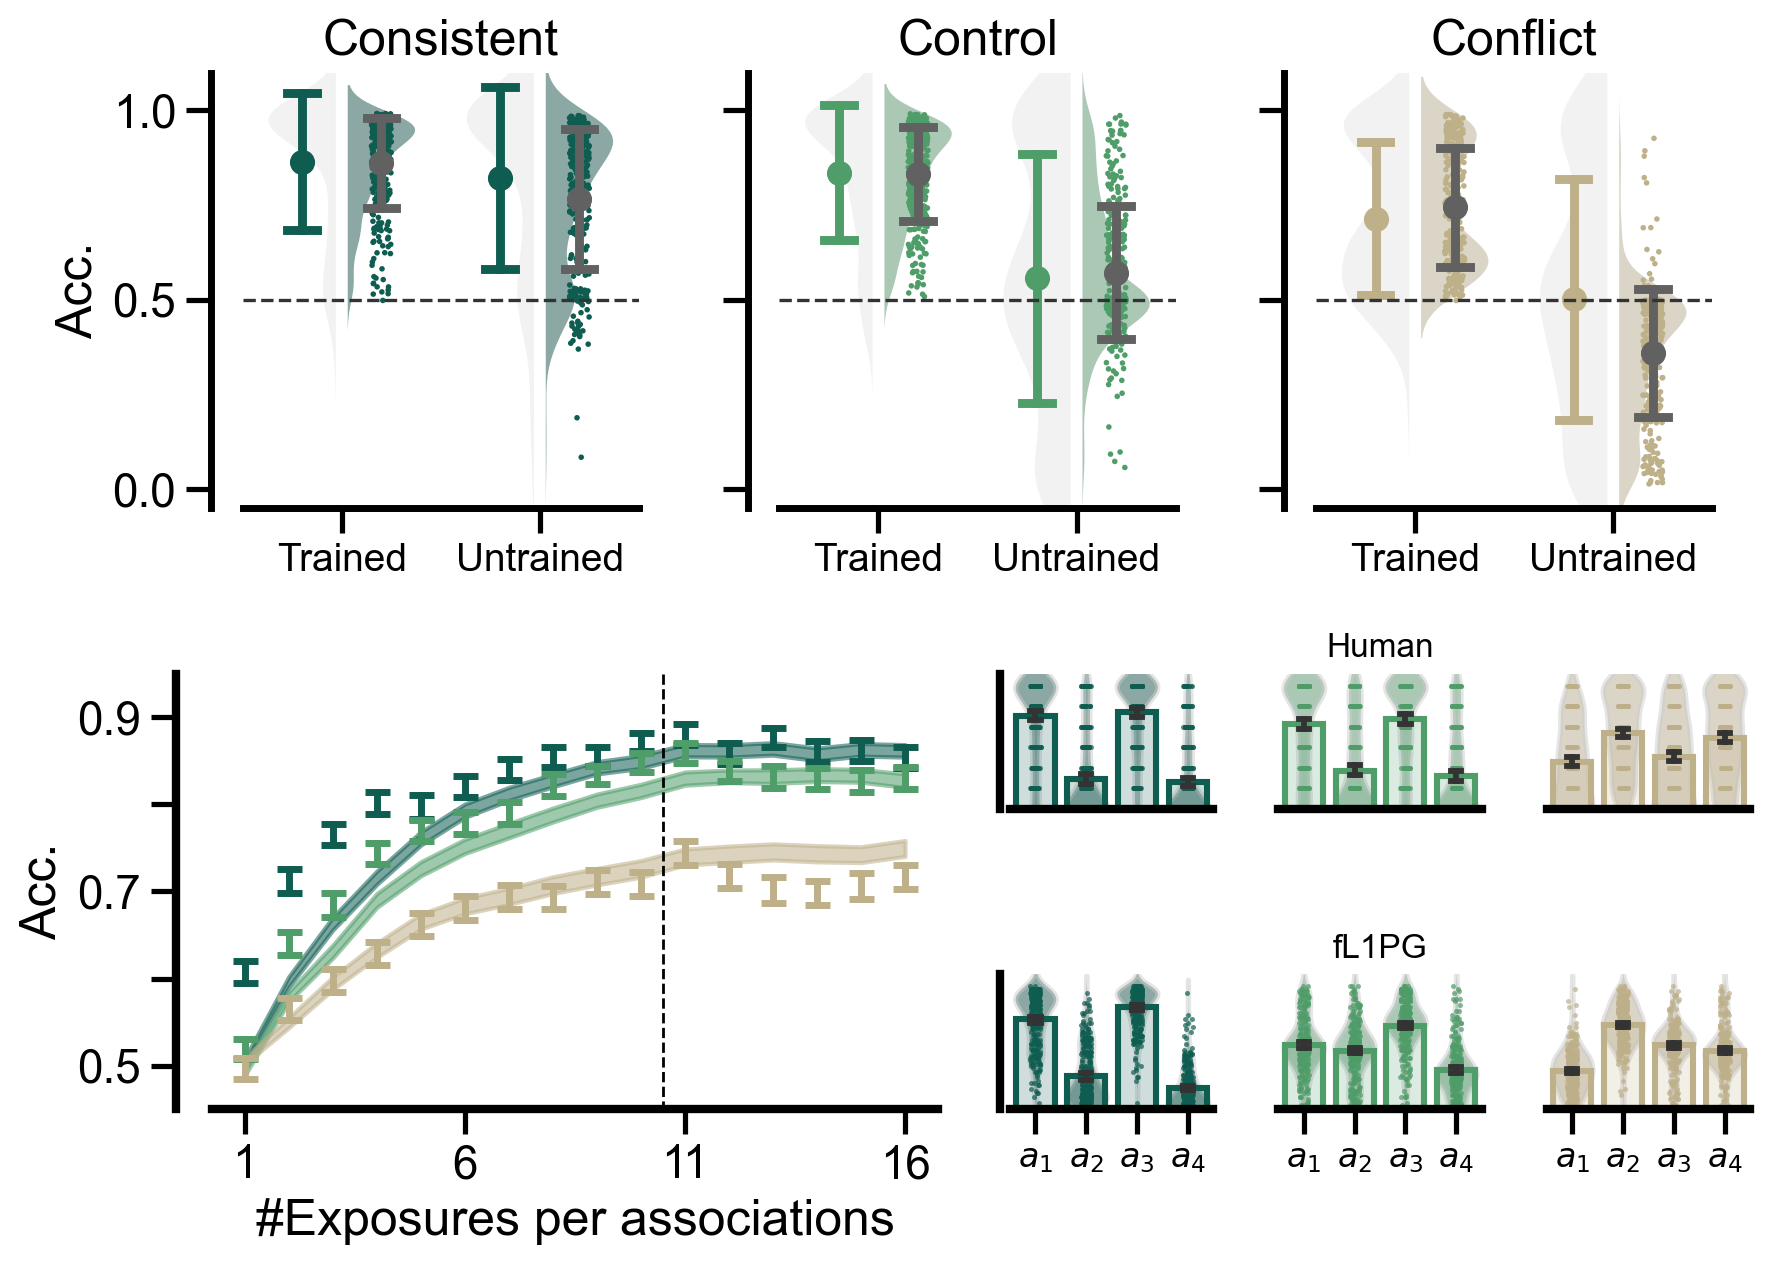

In [10]:
data_set = 'exp2'
model = 'l1PG_fea'
method = 'map'
get_phi(data_set, model, method)

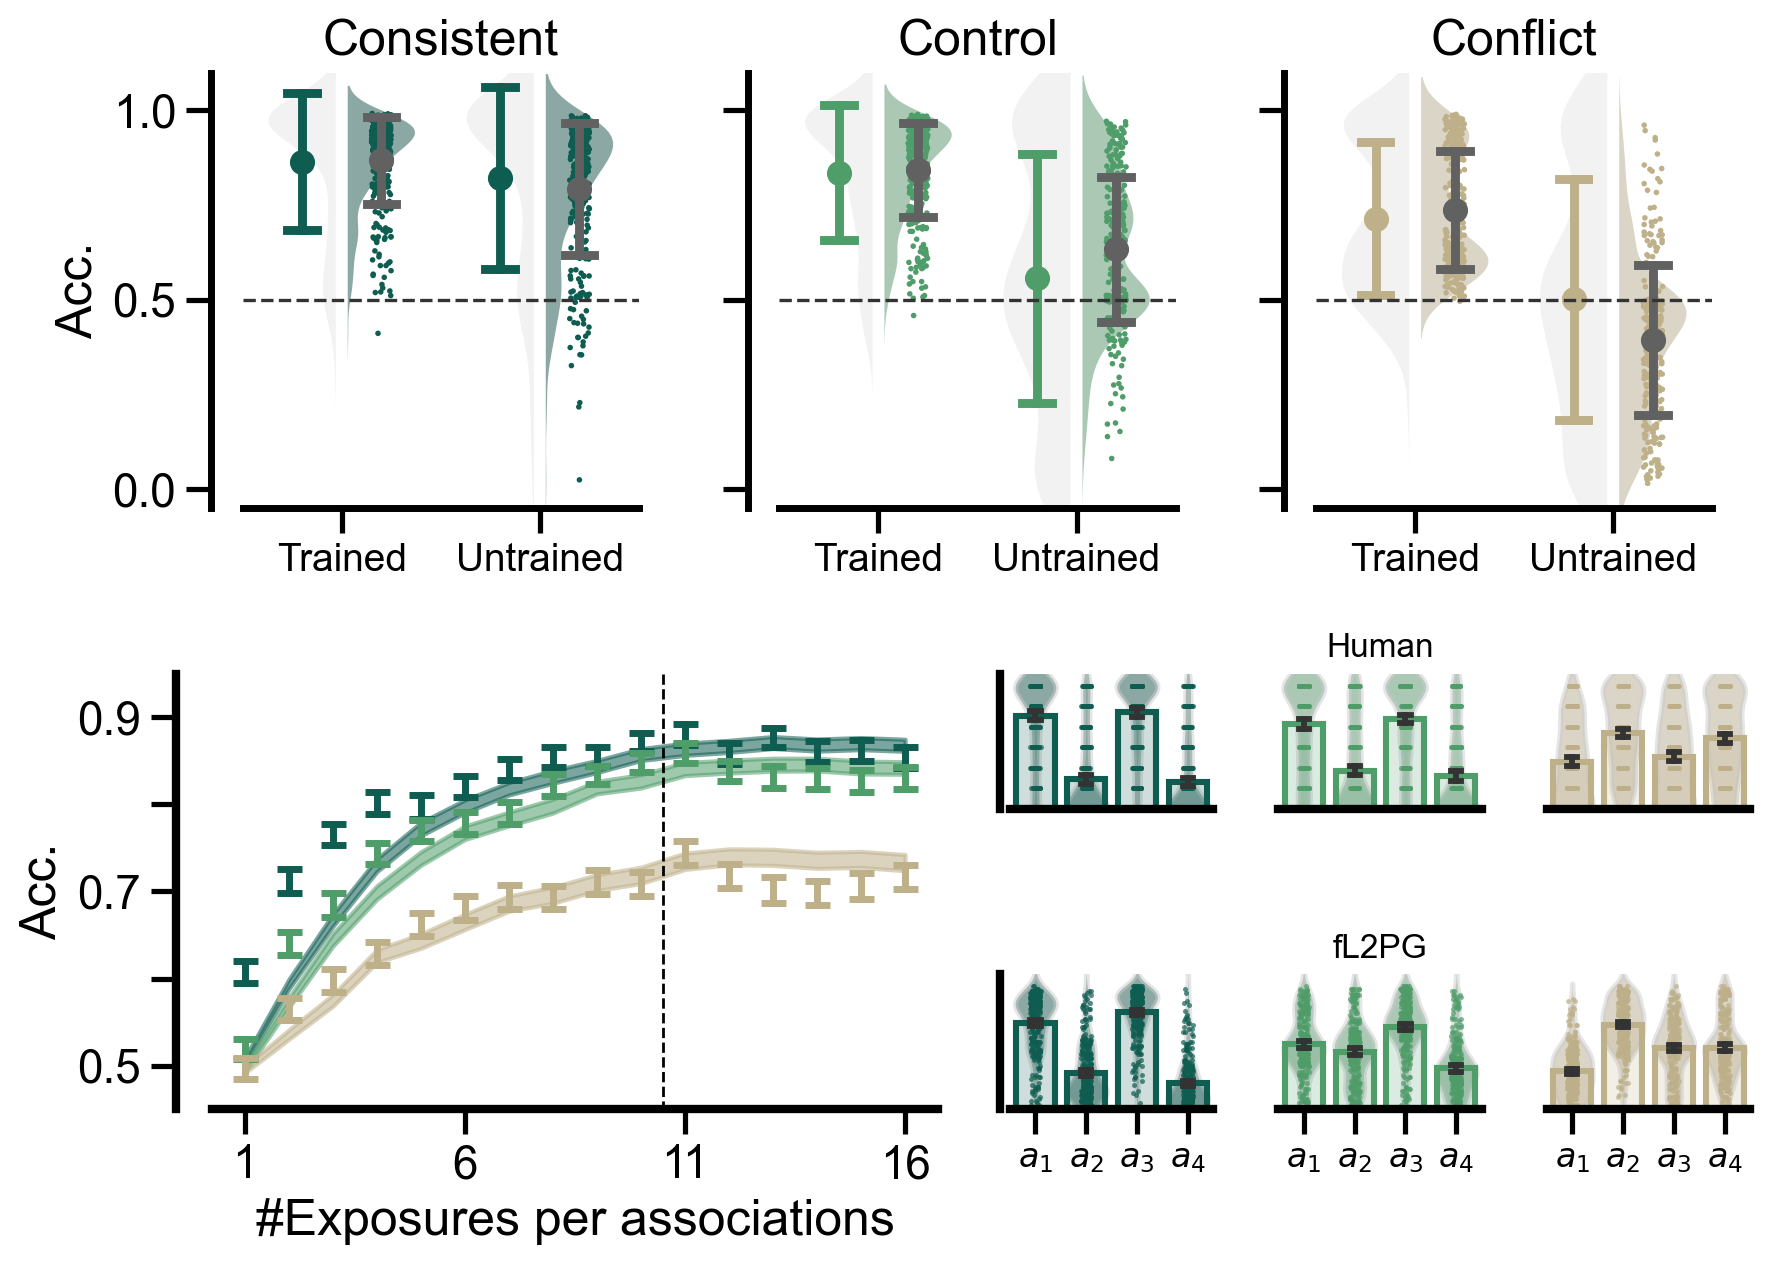

In [11]:
data_set = 'exp2'
model = 'l2PG_fea'
method = 'map'
get_phi(data_set, model, method)

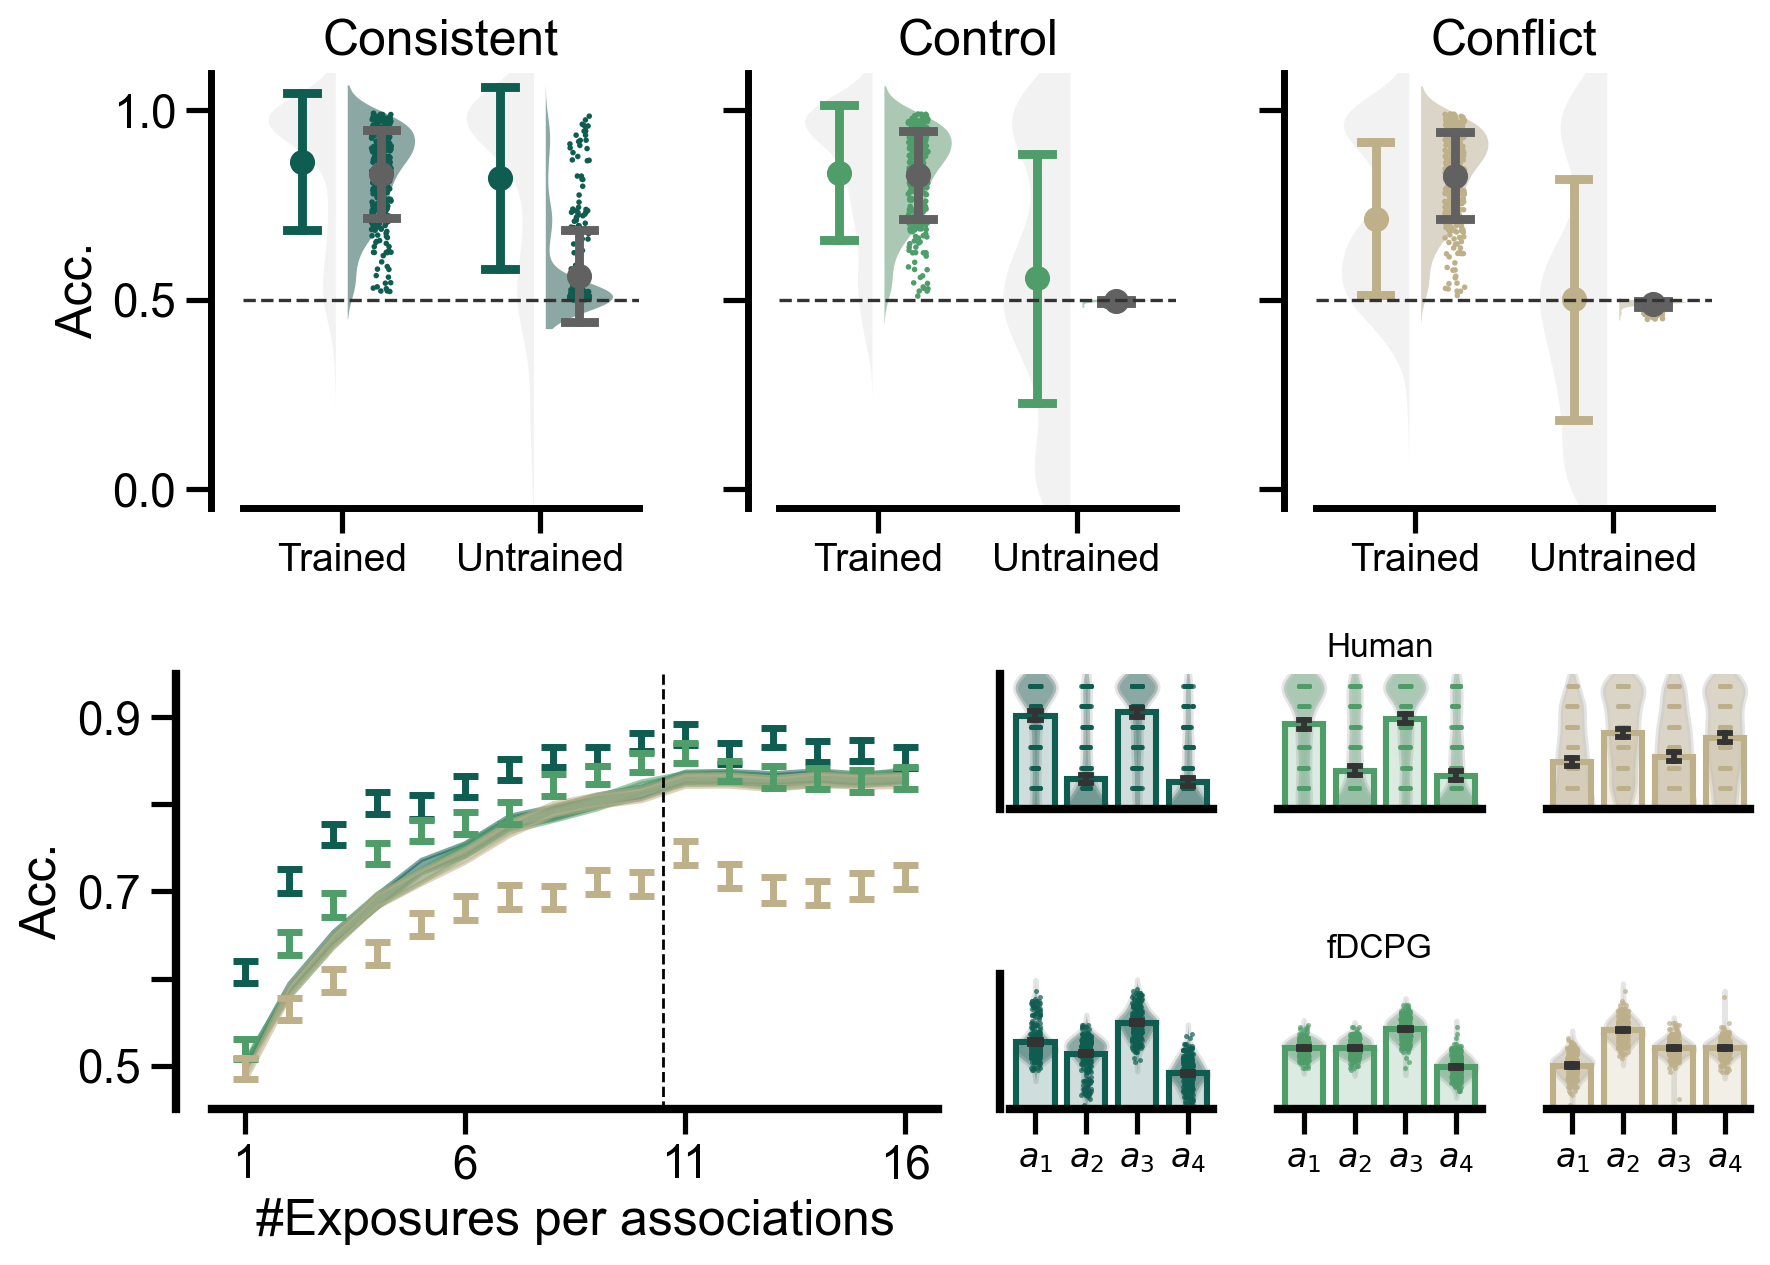

In [125]:
data_set = 'exp2'
model = 'dcPG_fea'
method = 'map'
get_phi(data_set, model, method)

## ECPG vs. L2PG

In [58]:
data_set = 'exp2'
models = ['l2PG_fea', 'ecPG_fea']
llh_table, _ = get_llh_score(data_set, models, method='map', if_bms=False, relative=True)
llh_table['sub_id'] = llh_table['sub_id'].apply(
    lambda x: int(x.split('_')[1])
)
llh_table['LL'] = -llh_table['NLL']
llh_table['representatives'] = llh_table['LL'].apply(
    lambda x: 'ECPG_like' if (x>0) else 'L2PG_like'
)
rep_lst = llh_table.query('model=="ecPG_fea"').loc[
    :, ['sub_id', 'representatives']]

In [59]:
ecpg_like_lst = llh_table.query('LL>0')['sub_id'].unique().tolist()
l2pg_like_lst = llh_table.query('LL<0')['sub_id'].unique().tolist()
print(f'# ECPG like: {len(ecpg_like_lst)}; L2PG like: {len(l2pg_like_lst)}')

# ECPG like: 199; L2PG like: 114


In [60]:
human_data = get_sim_data(data_set, 'human').merge(
            rep_lst, on='sub_id', how='left')
human_data['group'] = human_data['group'].map({
    'control': 'trained',
    'trained': 'trained',
    'untrained': 'untrained',
    'probe': 'probe'
})

For trained acc.
 	t(200.068)=5.907, p=0.000, cohen-d=0.732
For untrained acc.
 	t(269.490)=3.866, p=0.000, cohen-d=0.433


Text(21.444444444444443, 0.5, 'Accuracy')

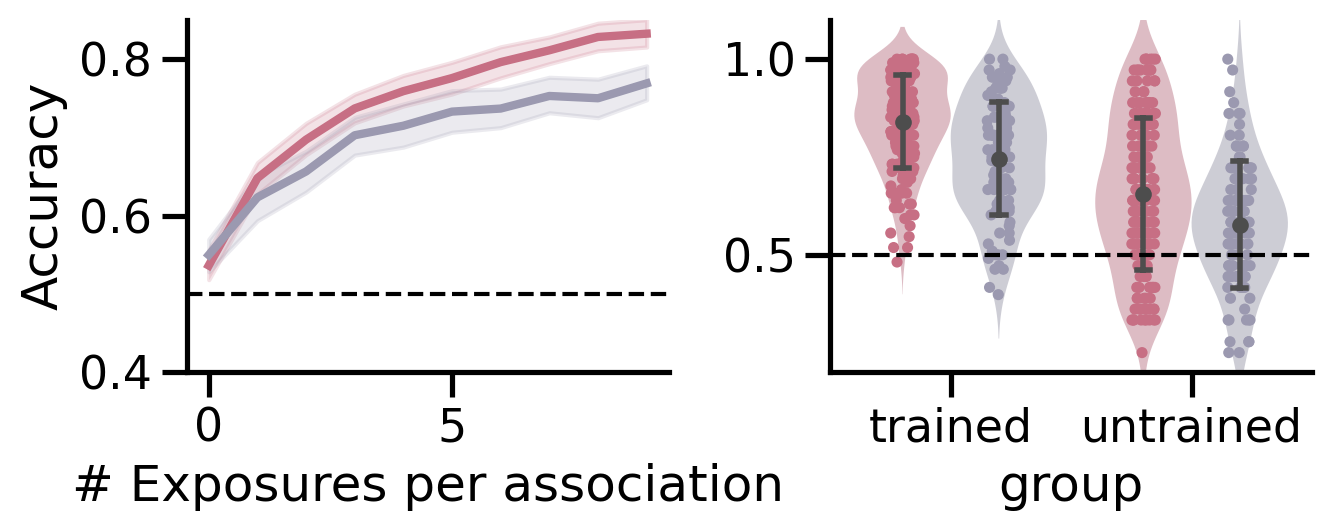

In [61]:
# generalization 
fig, axs = plt.subplots(1, 2, figsize=(7, 3.))
ax = axs[1]
sel_data = human_data.query('stage=="test"').groupby(
    by=['sub_id', 'representatives', 'group'])['r'].mean().reset_index()
viz.violin(ax, data=sel_data, y='r',
           x='group', order=['trained', 'untrained'],
           hue='representatives', hue_order=['ECPG_like', 'L2PG_like'],
           palette=[ecPG.color, l2PG.color],
           errorbar='sd', scatter_size=4,)
ax.axhline(y=.5, xmin=0, xmax=1, color='k', lw=1.5, ls='--')
ax.set_ylim([.2, 1.1])
fig.tight_layout()
ax.set_ylabel('')
print('For trained acc.')
x = sel_data.query(f'group=="trained"&representatives=="ECPG_like"')['r'].values
y = sel_data.query(f'group=="trained"&representatives=="L2PG_like"')['r'].values
t_test(x, y)
print('For untrained acc.')
x = sel_data.query(f'group=="untrained"&representatives=="ECPG_like"')['r'].values
y = sel_data.query(f'group=="untrained"&representatives=="L2PG_like"')['r'].values
t_test(x, y)
ax = axs[0]
sel_data = human_data.query('stage=="train"').groupby(
    by=['sub_id', 'representatives', 'tps'])['r'].mean().reset_index()
sns.lineplot(data=sel_data, y='r', x='tps', 
           hue='representatives', hue_order=['ECPG_like', 'L2PG_like'],
           palette=[ecPG.color, l2PG.color], lw=3, ax=ax,
           legend=False)
ax.axhline(y=.5, xmin=0, xmax=1, color='k', lw=1.5, ls='--')
ax.set_ylim([.4, .85])
fig.tight_layout()
ax.set_xlabel('# Exposures per association')
ax.set_ylabel('Accuracy')


In [150]:
sel_data = human_data.query('stage=="test"&group!="probe"').groupby(
    by=['sub_id', 'representatives', 'group', 'block_type'])['r'].mean().reset_index()
df1 = sel_data

In [193]:
d1 = get_sim_data('exp2', 'ecPG_fea', 'map').query('stage=="test"&group!="probe"').groupby(
    by=['sub_id', 'group', 'block_type'])['r'].mean().reset_index()
d1['representatives'] = 'ECPG_like'
d2 = get_sim_data('exp2', 'l2PG_fea', 'map').query('stage=="test"&group!="probe"').groupby(
    by=['sub_id', 'group', 'block_type'])['r'].mean().reset_index()
d2['representatives'] = 'L2PG_like'
df1 = pd.concat([d1, d2], axis=0)

In [194]:
ecpg_lmbda = get_fit_param(data_set, 'ecPG_fea', method='map').loc[:, ['sub_id', 'lmbda']]
ecpg_lmbda['sub_id'] = ecpg_lmbda['sub_id'].str.replace('subj_', '').astype(int)
l2pg_lmbda = get_fit_param(data_set, 'l2PG_fea', method='map').loc[:, ['sub_id', 'lmbda']]
l2pg_lmbda['sub_id'] = l2pg_lmbda['sub_id'].str.replace('subj_', '').astype(int)

# Combine the three dataframes on sub_id
combined_df = df1.merge(ecpg_lmbda, on='sub_id', how='outer', suffixes=('', '_ecpg'))
combined_df = combined_df.merge(l2pg_lmbda, on='sub_id', how='outer', suffixes=('', '_l2pg'))

# Rename columns for clarity
combined_df = combined_df.rename(columns={'lmbda': 'lmbda_ecpg', 'lmbda_l2pg': 'lmbda_l2pg'})

# Calculate 10th and 90th percentiles for both models
rm_pc = 1
ecpg_lower, ecpg_upper = np.percentile(combined_df['lmbda_ecpg'], [rm_pc, 100-rm_pc])
l2pg_lower, l2pg_upper = np.percentile(combined_df['lmbda_l2pg'], [rm_pc, 100-rm_pc])

# Filter data between 10%-90% quantiles
combined_df_filtered = combined_df[
    (combined_df['lmbda_ecpg'] >= ecpg_lower) & (combined_df['lmbda_ecpg'] <= ecpg_upper) &
    (combined_df['lmbda_l2pg'] >= l2pg_lower) & (combined_df['lmbda_l2pg'] <= l2pg_upper)
]

# Keep sub_id and representatives in df_filtered
df_filtered = pd.DataFrame({
    'sub_id': np.tile(combined_df_filtered['sub_id'], 2),
    'representatives': np.tile(combined_df_filtered['representatives'], 2),
    'r': np.tile(combined_df_filtered['r'], 2),
    'group': np.tile(combined_df_filtered['group'], 2),
    'block_type': np.tile(combined_df_filtered['block_type'], 2),
    'model': ['ecPG'] * len(combined_df_filtered) + ['l2PG'] * len(combined_df_filtered),
    'lmbda': np.concatenate([combined_df_filtered['lmbda_ecpg'], combined_df_filtered['lmbda_l2pg']])
})

# Add log_lmbda column
df_filtered['log_lmbda'] = np.log(df_filtered['lmbda'] + 1e-10)
df = df_filtered

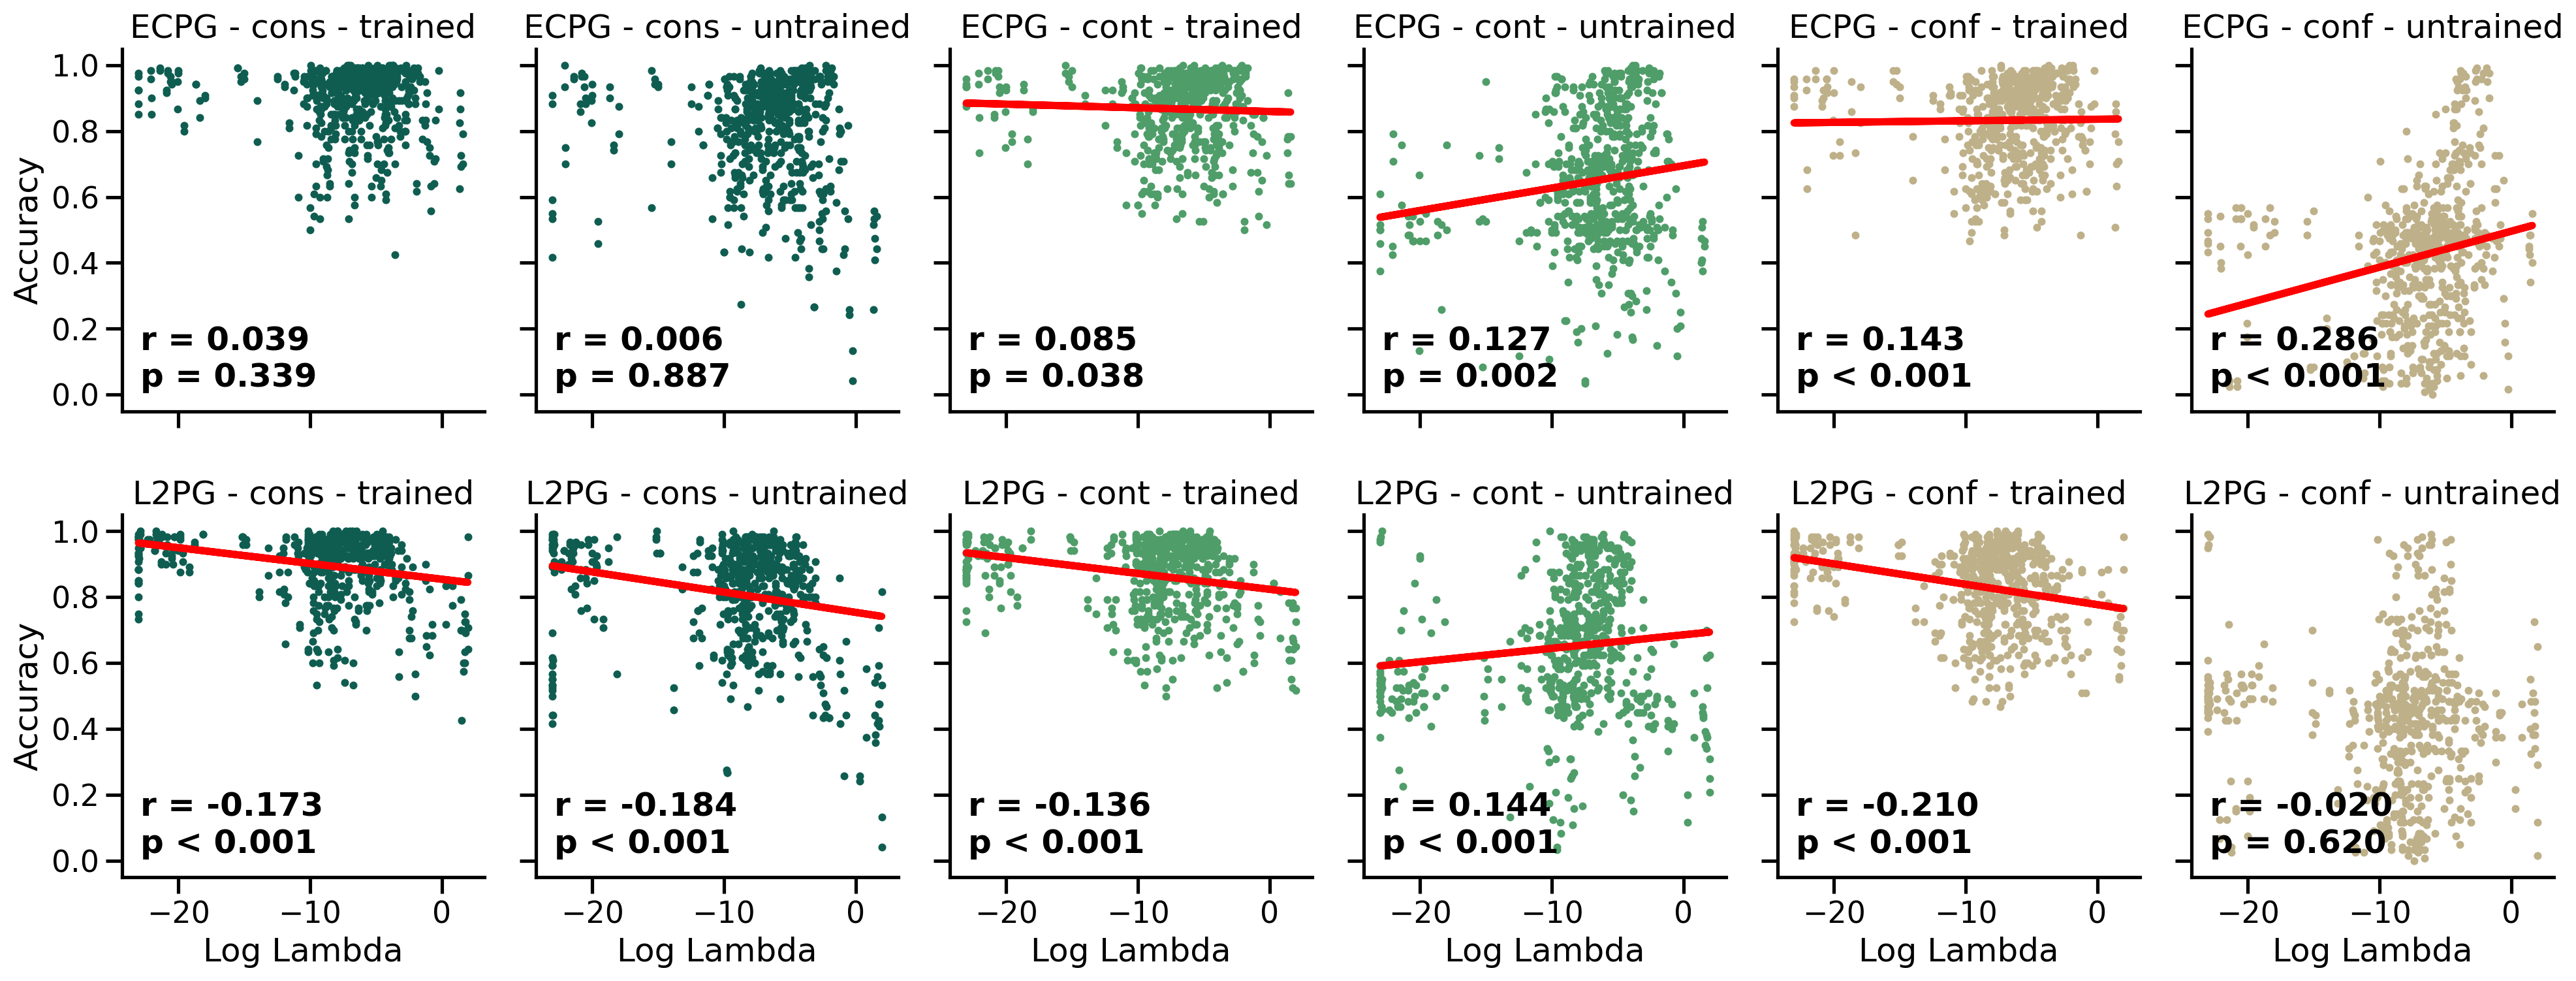

In [195]:
from scipy.stats import spearmanr, pearsonr

# Create a figure with subplots for all conditions
models = ['ecPG', 'l2PG']
block_types = ['cons', 'cont', 'conf']
groups = ['trained', 'untrained']

fig, axes = plt.subplots(len(models), len(block_types) * len(groups), figsize=(20, 8), 
                         sharex=True, sharey=True)
for i, model in enumerate(models):
    for j, block_type in enumerate(block_types):
        for k, group in enumerate(groups):
            ax_index = i * (len(block_types) * len(groups)) + j * len(groups) + k
            ax = axes.flatten()[ax_index]
            
            sel_df = df.query(f'model=="{model}" & block_type=="{block_type}" & group=="{group}"')
            
            # Scatterplot
            ax.scatter(sel_df['log_lmbda'], sel_df['r'], s=8, color=viz.Pal_type[j])
            ax.set_xlabel('Log Lambda') if ax_index//6==1 else ax.set_xlabel('')
            ax.set_ylabel('Accuracy') if ax_index%6==0 else ax.set_ylabel('')
            ax.set_title(f'{model.upper()} - {block_type} - {group}')
            
            # Calculate correlation
            corr_coef, p_value = spearmanr(sel_df['log_lmbda'], sel_df['r'])
            
            # Add correlation information to the plot
            p_text = f'p = {p_value:.3f}' if p_value>0.001 else  f'p < 0.001'
            ax.text(0.05, 0.05, f'r = {corr_coef:.3f}\n{p_text}', 
                     transform=ax.transAxes, verticalalignment='bottom', weight='bold')

            # Add regression line
            if p_value<.05:
                x = sel_df['log_lmbda']
                y = sel_df['r']
                m, b = np.polyfit(x, y, 1)
                ax.plot(x, m*x + b, color='red', linewidth=4)

            ax.set_box_aspect(1)

plt.tight_layout()
plt.show()

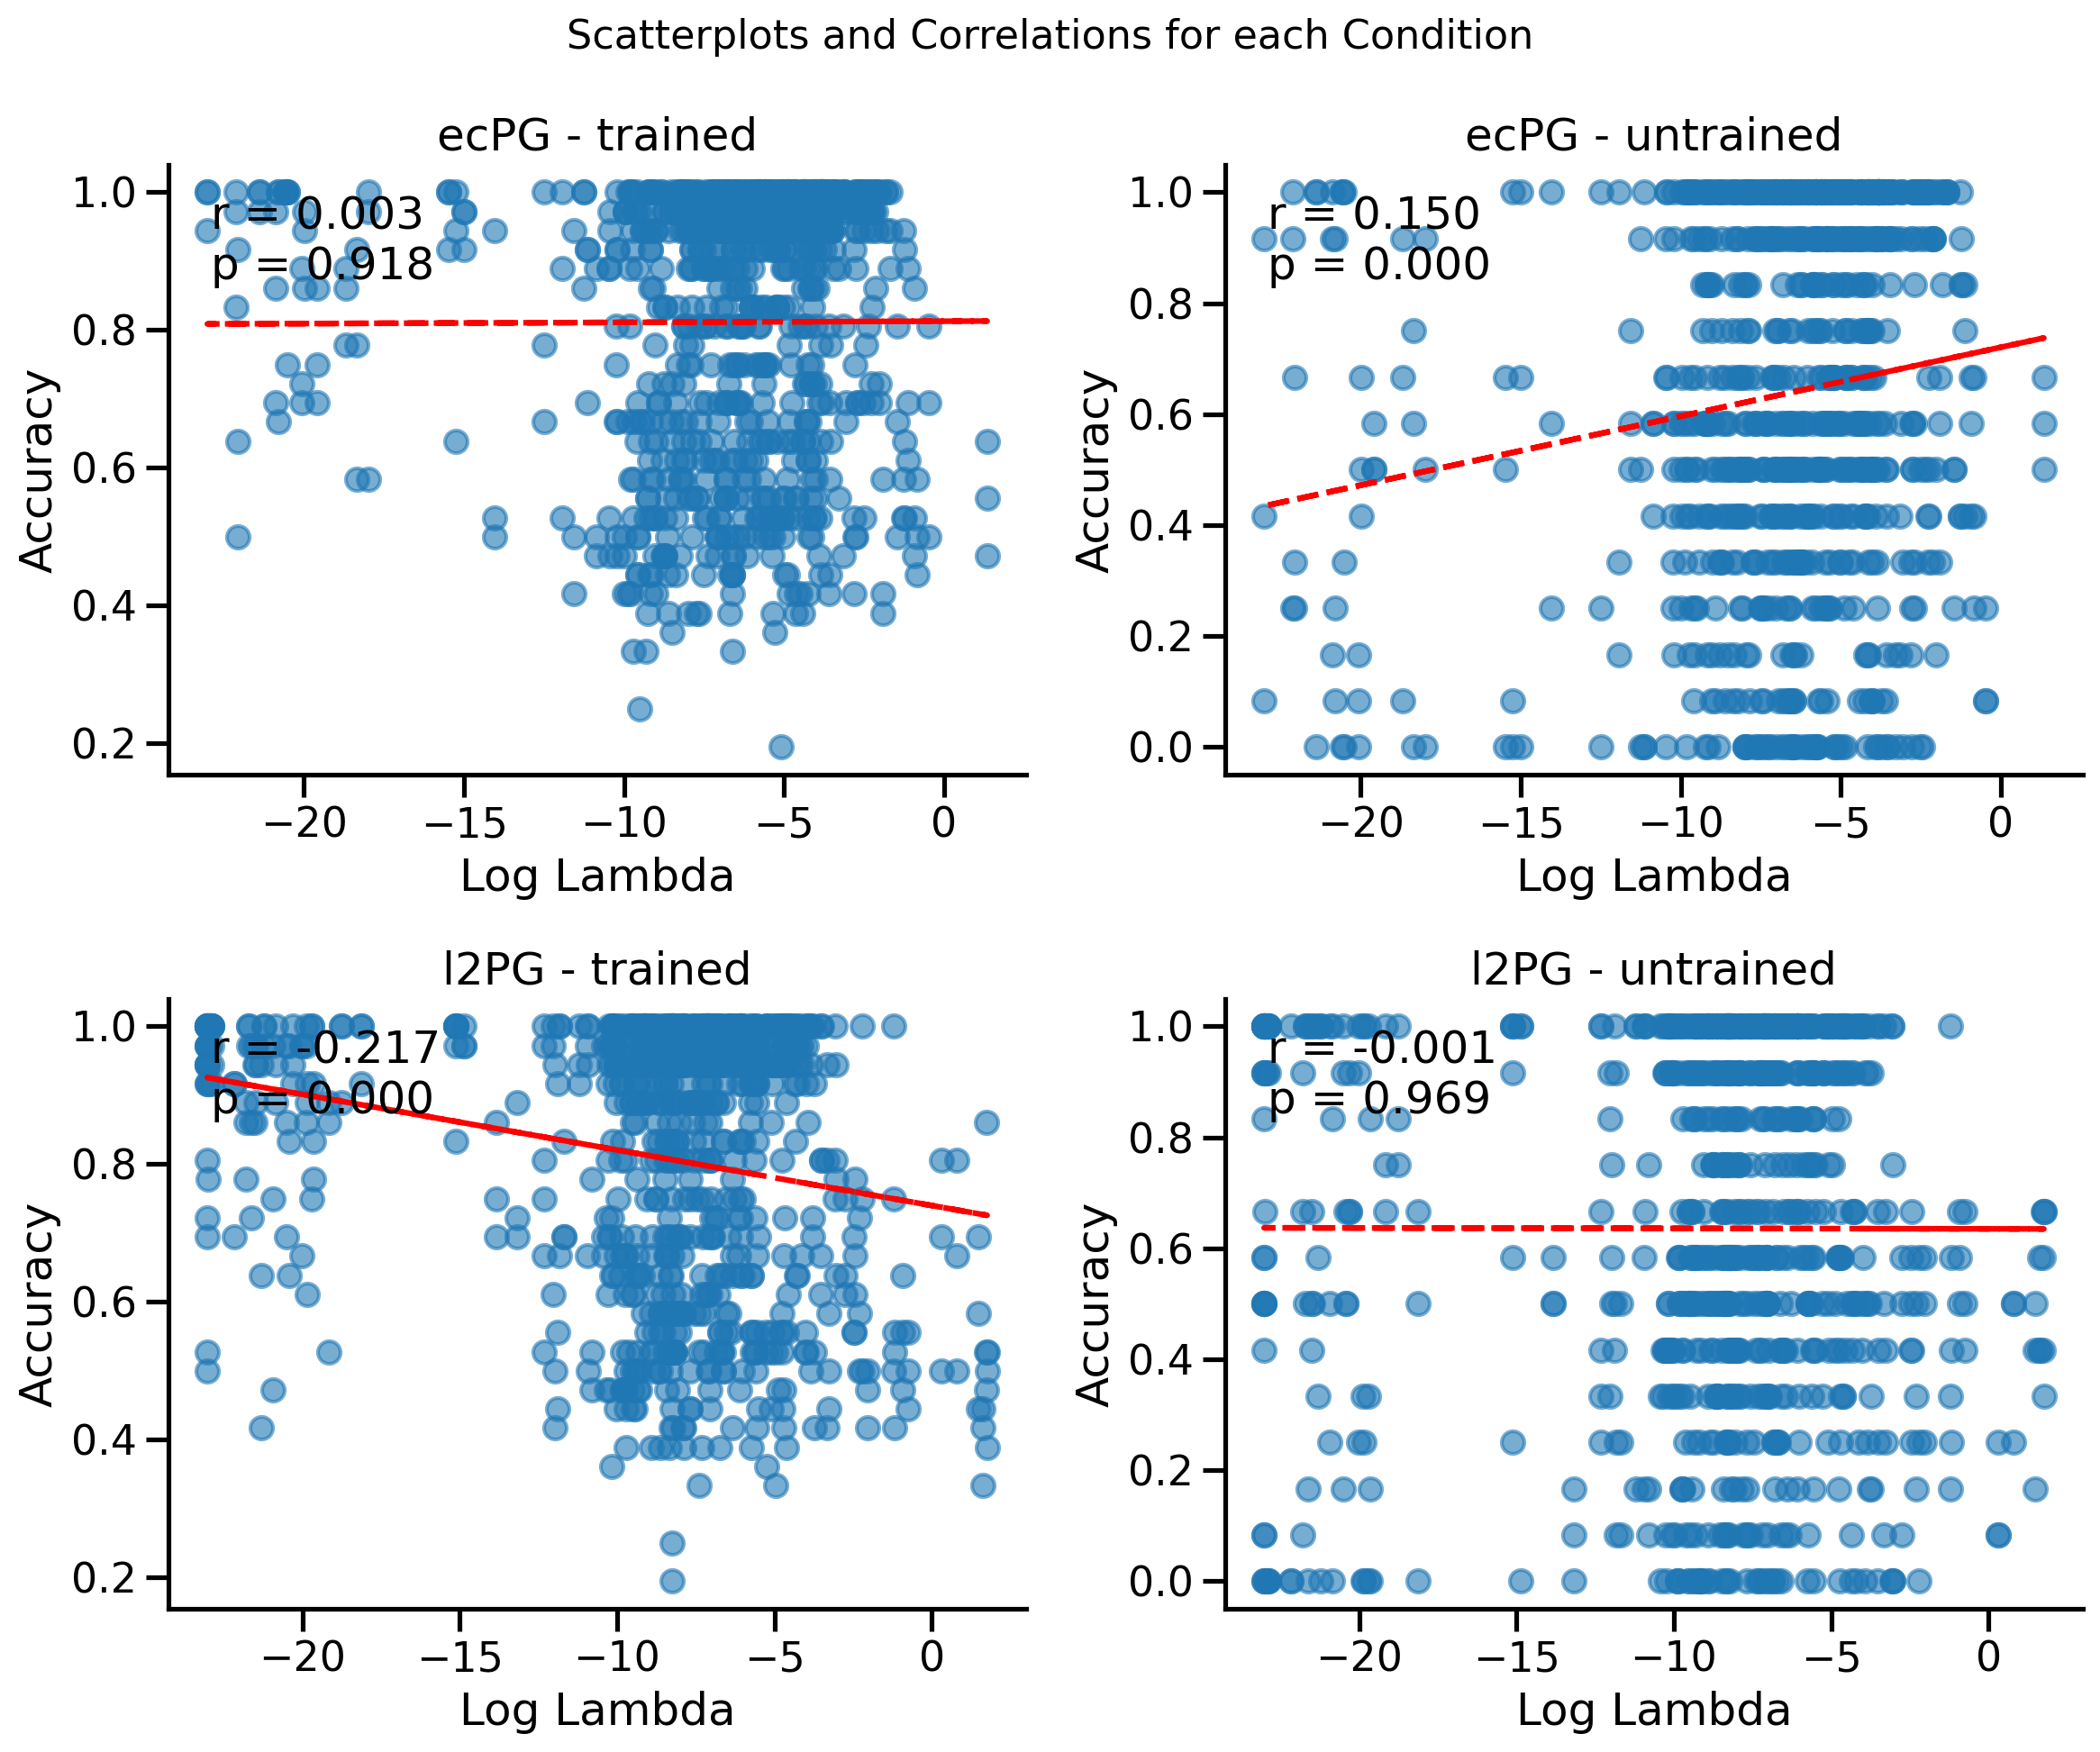

In [165]:
# Create a figure with subplots for each condition
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Scatterplots and Correlations for each Condition', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Define conditions
conditions = [
    ('ecPG', 'trained'),
    ('ecPG', 'untrained'),
    ('l2PG', 'trained'),
    ('l2PG', 'untrained')
]
from scipy.stats import pearsonr
# Plot scatterplots and calculate correlations for each condition
for i, (model, group) in enumerate(conditions):
    sel_df = df.query(f'model=="{model}" & group=="{group}"')
    
    # Scatterplot
    axes[i].scatter(sel_df['log_lmbda'], sel_df['r'], alpha=0.6)
    axes[i].set_xlabel('Log Lambda')
    axes[i].set_ylabel('Accuracy')
    axes[i].set_title(f'{model} - {group}')
    
    # Calculate correlation
    corr_coef, p_value = pearsonr(sel_df['log_lmbda'], sel_df['r'])
    
    # Add correlation information to the plot
    axes[i].text(0.05, 0.95, f'r = {corr_coef:.3f}\np = {p_value:.3f}', 
                 transform=axes[i].transAxes, verticalalignment='top')

    # Add regression line
    x = sel_df['log_lmbda']
    y = sel_df['r']
    m, b = np.polyfit(x, y, 1)
    axes[i].plot(x, m*x + b, color='red', linestyle='--')

plt.tight_layout()
plt.show()



In [146]:
# Perform t-test for ECPG_like group
ecpg_like = df[df['representatives'] == 'ECPG_like']
t_ecpg_like = t_test(ecpg_like[ecpg_like['model'] == 'ecPG']['lmbda'],
                     ecpg_like[ecpg_like['model'] == 'l2PG']['lmbda'],
                     paired=True)

# Perform t-test for L2PG_like group
l2pg_like = df[df['representatives'] == 'L2PG_like']
t_l2pg_like = t_test(l2pg_like[l2pg_like['model'] == 'ecPG']['lmbda'],
                     l2pg_like[l2pg_like['model'] == 'l2PG']['lmbda'],
                     paired=True)


 	t-paired(263.000)=9.069, p=0.000, cohen-d=0.790
 	t-paired(133.000)=2.935, p=0.004, cohen-d=0.339


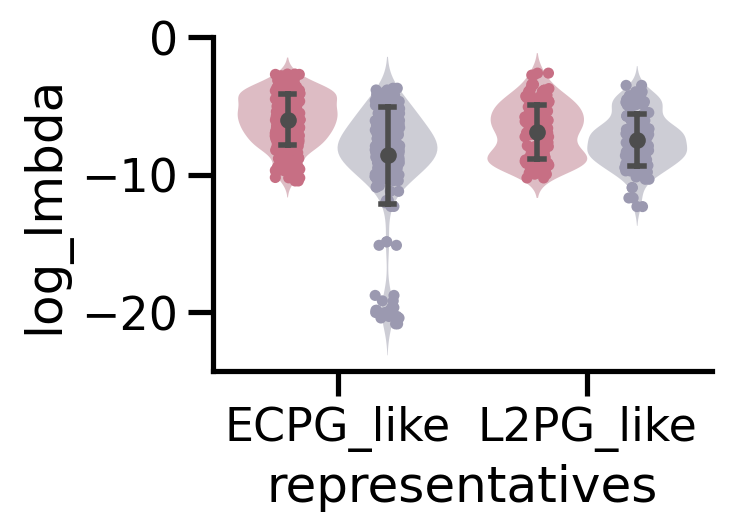

In [140]:
# generalization 
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax = ax
viz.violin(ax, data=df, y='log_lmbda',
           x='representatives', order=['ECPG_like', 'L2PG_like'],
           hue='model', hue_order=['ecPG', 'l2PG'],
           palette=[ecPG.color, l2PG.color],
           errorbar='sd', scatter_size=4,)
fig.tight_layout()



In [127]:
# Get lambda values for each model using query
df_ecpg = df.query("model == 'ecPG'")[['sub_id', 'representatives', 'r', 'lmbda']].rename(columns={'lmbda': 'lmbda_ecpg'})
df_l2pg = df.query("model == 'l2PG'")[['sub_id', 'lmbda']].rename(columns={'lmbda': 'lmbda_l2pg'})

# Combine the two dataframes on sub_id
df_combined = pd.merge(df_ecpg, df_l2pg, on='sub_id')

# Calculate lambda difference
df_combined['lmbda_diff'] = df_combined['lmbda_ecpg'] - df_combined['lmbda_l2pg']

corr(df_combined['lmbda_diff'], df_combined['r'])

 	r(214)=0.280, p=0.000
